In [0]:
!/opt/bin/nvidia-smi

Mon Apr 27 02:03:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from PIL import Image

import random
from matplotlib import pyplot as plt
from os import listdir, path
import os

from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from glob import glob
import torch
import numpy as np

from torchvision.transforms.transforms import Compose, Resize, ToTensor, CenterCrop
import time

import cv2


import warnings
warnings.filterwarnings('ignore')
import random
import skimage
from skimage import io
from skimage.transform import rotate, AffineTransform, warp
from skimage import util
from skimage.filters import gaussian


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def show_sample_images(root_dir='data', sample_size=10, from_class=None):    
    '''
    This function samples images from input data and shows them in a plot.
    Samples are with replacement out of the given class. If no class is given,
    samples are extracted from random classes.
    '''
    
    # number of images on the x and y axes should be relatively close
    for i in range(int(sample_size**0.5 + 1), 0, -1):
        if sample_size % i == 0:
            N_images_x = i
            N_images_y = int(sample_size/N_images_x)
            break
    
    # sample data directory and show image in subplots
    fig, ax = plt.subplots(N_images_x, N_images_y, squeeze=False)
    for sample_number in range(sample_size):
        if not from_class:
            dic = path.join(root_dir, 'images_200')
            labels_list = listdir(dic)
            label = str(random.sample(labels_list, 1)[0])
        
        parent_directory = path.join(root_dir, 'images_200', label)
        file_list = listdir(parent_directory)
        file_name = random.sample(file_list, 1)[0]
        img = Image.open(path.join(parent_directory, file_name))

        ax[sample_number % N_images_x][sample_number // N_images_x].imshow(img)
        ax[sample_number % N_images_x][sample_number // N_images_x].title.set_text(label)
        
    fig.set_figheight(N_images_y * 4)
    fig.set_figwidth(N_images_y * 4)
    fig.show()

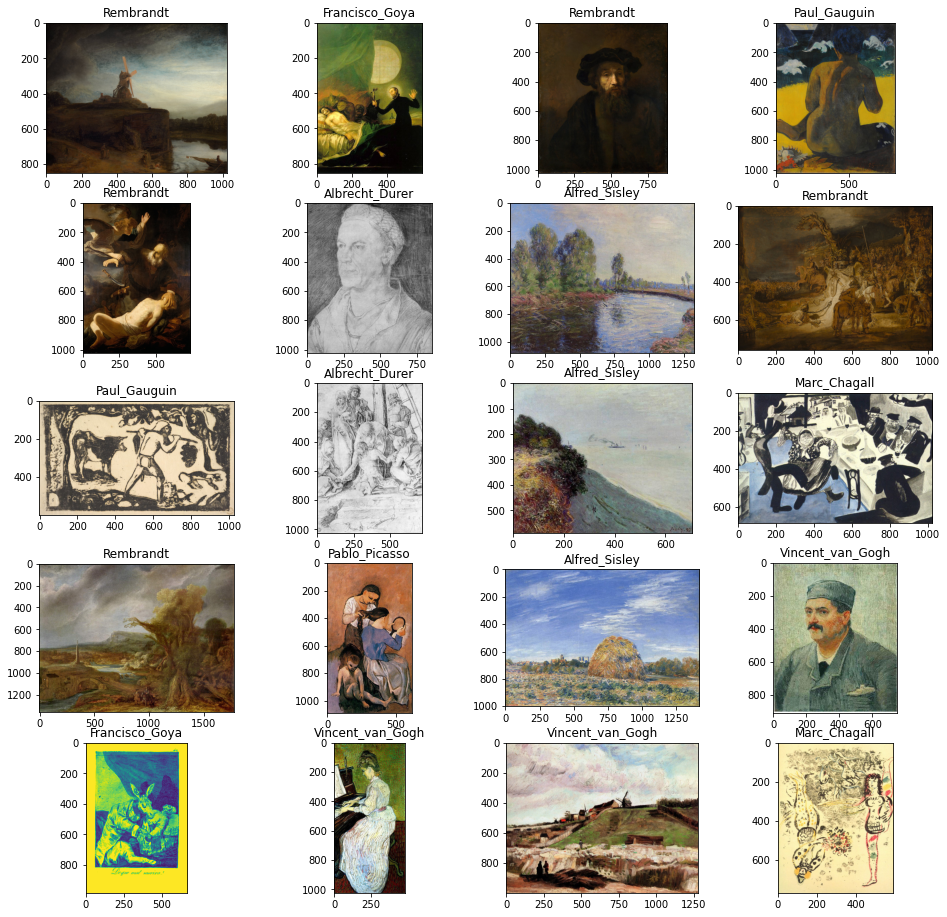

In [0]:
IMG_SIZE = 224
show_sample_images('drive/My Drive/503 project dataset', 20) # use for show the image


In [0]:
# define a class for the dataset
class SeedlingDataset(Dataset):
    
    def __init__(self, data, n_labels, transform=None):
        
        self.data = data
        self.transform = transform
        self.n_labels = n_labels
        self.transform = transform
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        data_file, image_code = self.data[idx]
        img = Image.open(data_file)
        img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)
        img = torch.from_numpy(np.array(img))
        label = torch.tensor(image_code)
        
        return img, label
    

def getDataLoaders(root_dir, train_transforms,test_transform, batch_size, test_ratio=0.2):
    
    '''
    This function defines train and test data loaders for the Seedling class of data.
    test_ratio is the ratio of the number of test images to the total number of images.
    '''
    
    all_labels = listdir(path.join(root_dir, 'images_200'))
    all_data = []
    print(all_labels)
    # Create a list of tuples out of data samples. Each tuple includes images file name and an int as label code
    for label_code, parent_dir in enumerate(all_labels):
        this_dir_images = glob(path.join(root_dir, 'images_200', parent_dir, '*.jpg'))
        all_data += zip(this_dir_images, [label_code]*len(this_dir_images))
    
    # Shuffle data and create train and test parts
    random.shuffle(all_data)
    n_train_examples = int(len(all_data) * (1 - test_ratio))
    test_path = all_data[n_train_examples:]
    test_data = SeedlingDataset(all_data[n_train_examples:], len(all_labels), transform=test_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

    all_data = all_data[:n_train_examples]
    train_path = all_data
    random.shuffle(all_data)
    train_data = SeedlingDataset(all_data, len(all_labels), transform=train_transforms)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)

    return train_loader, test_loader, train_path, test_path

def getDataLoaders_fix(root_dir, train_transforms,test_transform, batch_size, train_path, test_path):
    all_labels = listdir(path.join(root_dir, 'images_200'))
    test_data = SeedlingDataset(test_path, len(all_labels), transform=test_transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)

    train_data = SeedlingDataset(train_path, len(all_labels), transform=train_transforms)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    return train_loader, test_loader, train_path, test_path

In [0]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
from torchvision import datasets, transforms,models

train_augmentation_transform = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.RandomResizedCrop(256),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=10, translate=None, scale=(1,2), shear=None, resample=False, fillcolor=0),
     #transforms.ColorJitter(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)])

test_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(256), transforms.ToTensor(), transforms.Normalize(mean, std)])

train_loader, test_loader, train_path, test_path = getDataLoaders('drive/My Drive/503 project dataset', train_augmentation_transform, test_transform, batch_size=64, test_ratio=0.2)

In [0]:
img = Image.open(train_path[19][0])
img = img.convert('RGB')
img2 = train_augmentation_transform(img)
img2 = np.array(img2)
img2 = img2.transpose((1,2,0))
plt.imshow(img2)
img

In [0]:
import pandas as pd
#test_csv = pd.DataFrame(data=test_path)
#test_csv.to_csv('drive/My Drive/503 project dataset/CSV_format/test_csv.csv')
#train_csv = pd.DataFrame(data=train_path)
#train_csv.to_csv('drive/My Drive/503 project dataset/CSV_format/train_csv.csv')
#train_csv.head()

,0,1
0,drive/My Drive/503 project dataset/images_200/...,7
1,drive/My Drive/503 project dataset/images_200/...,5
2,drive/My Drive/503 project dataset/images_200/...,10
3,drive/My Drive/503 project dataset/images_200/...,7
4,drive/My Drive/503 project dataset/images_200/...,3


In [0]:
#test_pd = pd.read_csv('drive/My Drive/503 project dataset/CSV_format/test_csv.csv')
#test_path2 = np.array(test_pd).tolist()
#train_pd = pd.read_csv('drive/My Drive/503 project dataset/CSV_format/train_csv.csv')
#train_path2 = np.array(train_pd).tolist()

In [0]:
# 换了个模型试试 model3

import random
# random.seed(30)

from torchvision import datasets, transforms,models

model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
import torch.nn as nn
from collections import OrderedDict




class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

model.avgpool = nn.Sequential(
    AdaptiveConcatPool2d()
)


model.fc = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.25, inplace=False),
    nn.Linear(in_features=4096, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=11, bias=True)
)

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=5e-3) #想试试5e-3， 把下面的step_size改成20
# turn this off
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.15)

def train_model(model,
                train_loader,
                valid_loader,
                n_epochs,
                optimizer,
                scheduler,
                criterion,
                name="model.pt",
                path=None):
    # compare overfited
    train_loss_data, valid_loss_data, valid_acc = [], [], []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    accuracy_min = 86
    for epoch in range(n_epochs):
        print("Epoch: {}/{}".format(epoch + 1, n_epochs))
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        correct = 0
        e_since = time.time()


        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        scheduler.step()  # step up scheduler
        for images, labels in train_loader:
            # Move input and label tensors to the default device
            images, labels = images.to(device), labels.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            log_ps = model(images)
            # calculate the loss
            loss = criterion(log_ps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * images.size(0)

        ######################
        # validate the model #
        ######################
        print("\t\tGoing for validation")
        model.eval()  # prep model for evaluation
        for data, target in test_loader:
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            #print(target)
            


            # calculate the loss
            loss_p = criterion(output, target)
            # update running validation loss
            valid_loss += loss_p.item() * data.size(0)
            # calculate accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            #print(predicted)

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(test_loader.dataset)

        # calculate train loss and running loss
        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)
        valid_acc.append(correct / total * 100)

        print("\tTrain loss:{:.6f}..".format(train_loss),
              "\tValid Loss:{:.6f}..".format(valid_loss),
              "\tAccuracy: {:.4f}".format(correct / total * 100))
        

        # save model if Accuracy is large
        if correct / total * 100 >= accuracy_min:
            torch.save(model.state_dict(), "drive/My Drive/503 project dataset/model4_80.pth")
            accuracy_min = correct / total * 100

        # Time take for one epoch
        time_elapsed = time.time() - e_since
        print('\tEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    # compare total time
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # return the model
    return [model, train_loss_data, valid_loss_data, valid_acc]
total_epoch = 5
model, train_loss, valid_loss, valid_accuracy = train_model(model, train_loader,
          test_loader, total_epoch, optimizer,scheduler, criterion)

torch.save(model.state_dict(), "drive/My Drive/503 project dataset/model4.pth")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



Epoch: 1/5
		Going for validation
	Train loss:1.484900.. 	Valid Loss:1.061755.. 	Accuracy: 63.7698
	Epoch:1 completed in 27m 15s
Epoch: 2/5
		Going for validation
	Train loss:1.129390.. 	Valid Loss:0.974072.. 	Accuracy: 67.3815
	Epoch:2 completed in 2m 6s
Epoch: 3/5
		Going for validation
	Train loss:1.068349.. 	Valid Loss:1.025171.. 	Accuracy: 64.8984
	Epoch:3 completed in 2m 6s
Epoch: 4/5
		Going for validation
	Train loss:0.997607.. 	Valid Loss:0.845842.. 	Accuracy: 71.6704
	Epoch:4 completed in 2m 6s
Epoch: 5/5
		Going for validation
	Train loss:0.971213.. 	Valid Loss:0.904962.. 	Accuracy: 69.1874
	Epoch:5 completed in 2m 7s
Training completed in 35m 39s


In [0]:
model.load_state_dict(torch.load('drive/My Drive/503 project dataset/model4_80.pth'))
#torch.load('D:/507_plant_classification/model_save/1500_balance_bs64_e14_20.pt',map_location=torch.device('cpu'))
nb_classes = 11
model.eval() # model A

confusion_matrix_A = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
            confusion_matrix_A[t.long(), p.long()] += 1
print(confusion_matrix_A)
print(confusion_matrix_A.diag()/confusion_matrix_A.sum(1))

tensor([[ 62.,   1.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   2.],
        [  2.,  53.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.],
        [  0.,   0.,  61.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.],
        [  0.,   0.,   0.,  39.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0., 138.,   0.,   0.,   1.,   2.,   5.],
        [  2.,   5.,   0.,   0.,   0.,   0.,  45.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,  51.,   0.,   0.,   1.],
        [  0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,  54.,   1.,   0.],
        [  1.,   0.,   1.,   1.,   0.,   2.,   0.,   0.,   1.,  87.,   1.],
        [  0.,   0.,   0.,   1.,   0.,   1.,   0.,   2.,   1.,   1., 185.],
        [  1.,   0.,   0.,   1.,  65.,   0.,   0.,   0.,   0.,   0.,   0.]])
tensor([0.9118, 0.9298, 0.9683, 1.0000, 0.0000, 0.0000, 0.0000, 0.0175, 0.0106,
        0.0052, 0.0000])


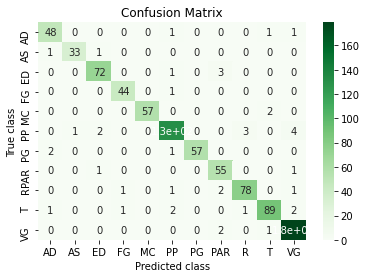

In [0]:
import pandas as pd
import seaborn as sns

CATEGORIES = ['Albrecht_Durer',
 'Alfred_Sisley',
 'Edgar_Degas',
 'Francisco_Goya',
 'Marc_Chagall',
 'Pablo_Picasso',
 'Paul_Gauguin',
 'Pierre-Auguste_Renoir',
 'Rembrandt',
 'Titian',
 'Vincent_van_Gogh']

abbreviation = ['AD', 'AS', 'ED', 'FG', 'MC', 'PP', 'PG', 'PAR', 'R', 'T', 'VG']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})
fig, ax = plt.subplots(1)
ax = sns.heatmap(confusion_matrix_A, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show()

In [0]:
# 换了个模型试试 model5


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


test_transform = Compose([Resize(256), CenterCrop(256), ToTensor(), transforms.Normalize(mean, std)])

train_loader, test_loader, train_path, test_path = getDataLoaders('drive/My Drive/503 project dataset', test_transform, test_transform, batch_size=64, test_ratio=0.2)



import random
# random.seed(30)

from torchvision import datasets, transforms,models

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
import torch.nn as nn
from collections import OrderedDict

class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

model.avgpool = nn.Sequential(
    AdaptiveConcatPool2d()
)

model.fc = nn.Sequential(
    nn.Flatten(),
    nn.BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.25, inplace=False),
    nn.Linear(in_features=4096, out_features=512, bias=True),
    nn.ReLU(inplace=True),
    nn.BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=512, out_features=11, bias=True)
)
criterion = nn.CrossEntropyLoss()

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=5e-3) #想试试5e-3， 把下面的step_size改成20
# turn this off
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.15)

def train_model(model,
                train_loader,
                valid_loader,
                n_epochs,
                optimizer,
                scheduler,
                criterion,
                name="model.pt",
                path=None):
    # compare overfited
    train_loss_data, valid_loss_data, valid_acc = [], [], []
    # check for validation loss
    valid_loss_min = np.Inf
    # calculate time
    since = time.time()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    accuracy_min = 87

    for epoch in range(n_epochs):
        print("Epoch: {}/{}".format(epoch + 1, n_epochs))
        # monitor training loss
        train_loss = 0.0
        valid_loss = 0.0
        total = 0
        correct = 0
        e_since = time.time()


        ###################
        # train the model #
        ###################
        model.train()  # prep model for training
        scheduler.step()  # step up scheduler
        for images, labels in train_loader:
            # Move input and label tensors to the default device
            images, labels = images.to(device), labels.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            log_ps = model(images)
            # calculate the loss
            loss = criterion(log_ps, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * images.size(0)

        ######################
        # validate the model #
        ######################
        print("\t\tGoing for validation")
        model.eval()  # prep model for evaluation
        for data, target in test_loader:
            # Move input and label tensors to the default device
            data, target = data.to(device), target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)

            #print(target)
            


            # calculate the loss
            loss_p = criterion(output, target)
            # update running validation loss
            valid_loss += loss_p.item() * data.size(0)
            # calculate accuracy
            proba = torch.exp(output)
            top_p, top_class = proba.topk(1, dim=1)
            equals = top_class == target.view(*top_class.shape)

            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            #print(predicted)

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.dataset)
        valid_loss = valid_loss / len(test_loader.dataset)

        # calculate train loss and running loss
        train_loss_data.append(train_loss * 100)
        valid_loss_data.append(valid_loss * 100)
        valid_acc.append(correct / total * 100)

        print("\tTrain loss:{:.6f}..".format(train_loss),
              "\tValid Loss:{:.6f}..".format(valid_loss),
              "\tAccuracy: {:.4f}".format(correct / total * 100))
        

        # save model if Accuracy is large
        if correct / total * 100 >= accuracy_min:
            torch.save(model.state_dict(), "drive/My Drive/503 project dataset/model5_87.pth")
            accuracy_min = correct / total * 100

        # Time take for one epoch
        time_elapsed = time.time() - e_since
        print('\tEpoch:{} completed in {:.0f}m {:.0f}s'.format(
            epoch + 1, time_elapsed // 60, time_elapsed % 60))

    # compare total time
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # return the model
    return [model, train_loss_data, valid_loss_data, valid_acc]
total_epoch = 25
model, train_loss, valid_loss, valid_accuracy = train_model(model, train_loader,
          test_loader, total_epoch, optimizer,scheduler, criterion)

torch.save(model.state_dict(), "drive/My Drive/503 project dataset/model5.pth")

['Francisco_Goya', 'Titian', 'Pierre-Auguste_Renoir', 'Marc_Chagall', 'Edgar_Degas', 'Rembrandt', 'Alfred_Sisley', 'Paul_Gauguin', 'Pablo_Picasso', 'Vincent_van_Gogh', 'Albrecht_Durer', 'models']
Epoch: 1/25
		Going for validation
	Train loss:0.995373.. 	Valid Loss:0.604532.. 	Accuracy: 80.5869
	Epoch:1 completed in 2m 2s
Epoch: 2/25
		Going for validation
	Train loss:0.490520.. 	Valid Loss:0.614677.. 	Accuracy: 81.7156
	Epoch:2 completed in 2m 2s
Epoch: 3/25
		Going for validation
	Train loss:0.355452.. 	Valid Loss:0.593899.. 	Accuracy: 81.8284
	Epoch:3 completed in 2m 3s
Epoch: 4/25
		Going for validation
	Train loss:0.270939.. 	Valid Loss:0.571387.. 	Accuracy: 82.3928
	Epoch:4 completed in 2m 2s
Epoch: 5/25
		Going for validation
	Train loss:0.151180.. 	Valid Loss:0.517714.. 	Accuracy: 85.2144
	Epoch:5 completed in 2m 2s
Epoch: 6/25
		Going for validation
	Train loss:0.116213.. 	Valid Loss:0.512031.. 	Accuracy: 85.3273
	Epoch:6 completed in 2m 5s
Epoch: 7/25
		Going for validation
	

Next is fast.ai method.

First import packages and  fastai.

In [0]:
from pathlib import Path
from fastai.vision import *
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from fastai import basic_train

from fastai.callbacks import *

!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


Then define classes, batch size, image size and neural network strcture.(here pretrined model) 

In [0]:
artists = np.array(['Francisco_Goya', 'Titian', 'Pierre-Auguste_Renoir', 'Marc_Chagall', 'Edgar_Degas', 'Rembrandt', 'Alfred_Sisley', 'Paul_Gauguin', 'Pablo_Picasso', 'Vincent_van_Gogh', 'Albrecht_Durer'],dtype = object)
bs,size = 64,256
arch = models.resnet50

We don't use the following codes.

In [0]:
src = (ImageList.from_folder("drive/My Drive/503 project dataset/images_200")
.filter_by_folder(include=artists)
.filter_by_func(lambda fname: Path(fname).suffix == '.jpg')
.split_by_rand_pct()
.label_from_folder())
data_test= (src.transform(get_transforms(),size=size)
           .databunch(bs=bs).normalize(imagenet_stats))

Prepare ths data. Do data augmentation.

In [0]:
data_test = (ImageList.from_folder("drive/My Drive/503 project dataset/train_test_split")
        .split_by_folder(train='train', valid='test')
        .label_from_folder()
        .transform(get_transforms(),size=size)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
       ) 

In [0]:
data_test

ImageDataBunch;

Train: LabelList (3989 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Albrecht_Durer,Albrecht_Durer,Albrecht_Durer,Albrecht_Durer,Albrecht_Durer
Path: drive/My Drive/503 project dataset/train_test_split;

Valid: LabelList (440 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
Pierre-Auguste_Renoir,Pierre-Auguste_Renoir,Pierre-Auguste_Renoir,Pierre-Auguste_Renoir,Pierre-Auguste_Renoir
Path: drive/My Drive/503 project dataset/train_test_split;

Test: None

Define the learn model.

In [0]:
learn = cnn_learner(data_test, arch, metrics=accuracy)

In [0]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

Find the best learning rate.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


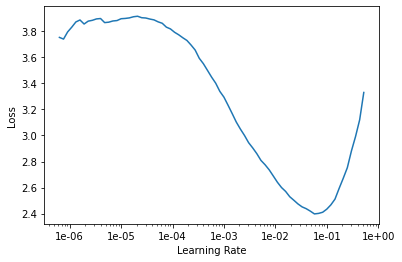

In [0]:
learn.lr_find()
learn.recorder.plot()

Fit 20 epoches and save the best model in path "models".

In [0]:
learn.fit_one_cycle(20, 5e-3, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,time
0,1.544237,0.679906,0.768182,03:43
1,0.909956,0.559361,0.795455,03:38
2,0.644474,0.603604,0.802273,03:37
3,0.536702,0.513462,0.825000,03:37
4,0.508463,0.688655,0.804545,03:37
5,0.485862,0.615642,0.813636,03:35
6,0.486509,0.841712,0.765909,03:35
7,0.466028,0.738400,0.784091,03:34
8,0.375358,0.507438,0.868182,03:35
9,0.354627,0.627069,0.818182,03:34


Better model found at epoch 0 with accuracy value: 0.7681818008422852.
Better model found at epoch 1 with accuracy value: 0.7954545617103577.
Better model found at epoch 2 with accuracy value: 0.8022727370262146.
Better model found at epoch 3 with accuracy value: 0.824999988079071.
Better model found at epoch 8 with accuracy value: 0.8681818246841431.
Better model found at epoch 13 with accuracy value: 0.9272727370262146.
Better model found at epoch 18 with accuracy value: 0.9295454621315002.


AttributeError: ignored

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


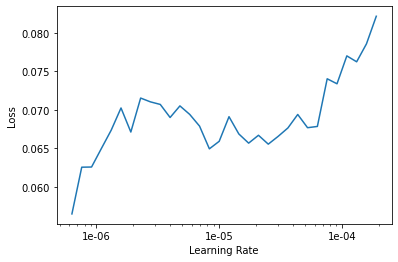

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-7,1e-6), callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best-1')])

epoch,train_loss,valid_loss,accuracy,time
0,0.059667,0.245229,0.922727,03:36
1,0.068860,0.237178,0.922727,03:36
2,0.069197,0.256308,0.918182,03:37
3,0.071389,0.244275,0.927273,03:38
4,0.066822,0.247046,0.913636,03:36


Better model found at epoch 0 with accuracy value: 0.9227272868156433.
Better model found at epoch 3 with accuracy value: 0.9272727370262146.


Next time if you want to load the saved model, first prepare the data in the same way, then define learn in the same way, then load model. Then you can use it to predict the valid. 

In [0]:
#learn = cnn_learner(data_test, arch, metrics=accuracy)
learn.load("best")

preds, classes = learn.get_preds()

In [0]:
preds

tensor([[5.1954e-10, 4.9250e-09, 9.5099e-10,  ..., 1.5822e-09, 4.0719e-11,
         6.2904e-09],
        [3.8762e-07, 1.2241e-05, 2.6299e-02,  ..., 3.9299e-05, 1.7421e-07,
         4.8290e-07],
        [4.0278e-05, 2.9075e-05, 3.4602e-02,  ..., 1.8501e-01, 2.5177e-05,
         5.6046e-02],
        ...,
        [1.1352e-08, 2.4433e-06, 1.6719e-05,  ..., 1.5766e-10, 3.5441e-07,
         9.9998e-01],
        [1.0685e-07, 7.4838e-07, 3.1123e-05,  ..., 1.6251e-09, 5.8434e-07,
         9.9689e-01],
        [4.2645e-05, 3.1413e-04, 5.1400e-01,  ..., 1.2800e-02, 3.6856e-02,
         2.3370e-01]])

In [0]:
from sklearn.metrics import f1_score, precision_score, recall_score
_, preds2 = torch.max(preds, 1)

f1 = f1_score(classes.cpu().numpy(), preds2.cpu().numpy(), average='macro')
p = precision_score(classes.cpu().numpy(), preds2.cpu().numpy(), average="macro")
r = recall_score(classes.cpu().numpy(), preds2.cpu().numpy(), average="macro")
print(f1, p, r)

print(f1_score(classes.cpu(), preds2.cpu(), average=None))
print(precision_score(classes.cpu(), preds2.cpu(), average=None))
print(recall_score(classes.cpu(), preds2.cpu(), average=None))

0.9276694645333889 0.9310282959538942 0.9272727272727274
[1.       0.938272 0.896552 0.906667 0.961039 0.911392 0.91358  0.947368 0.915663 0.911392 0.902439]
[1.       0.926829 0.829787 0.971429 1.       0.923077 0.902439 1.       0.883721 0.923077 0.880952]
[1.    0.95  0.975 0.85  0.925 0.9   0.925 0.9   0.95  0.9   0.925]


In [0]:
nb_classes = 11
confusion_matrix_A = torch.zeros(nb_classes, nb_classes)

_, preds2 = torch.max(preds, 1)
for t, p in zip(classes.view(-1), preds2.view(-1)):
    confusion_matrix_A[t.long(), p.long()] += 1

confusion_matrix_A
print(confusion_matrix_A)
print(confusion_matrix_A.diag()/confusion_matrix_A.sum(1))
print(confusion_matrix_A.diag().sum()/confusion_matrix_A.sum())

tensor([[40.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 38.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.],
        [ 0.,  0., 39.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 34.,  0.,  0.,  0.,  0.,  1.,  1.,  4.],
        [ 0.,  0.,  1.,  0., 37.,  2.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  3.,  0.,  0., 36.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  2.,  0.,  0.,  0., 37.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  1.,  1.,  0.,  0.,  1., 36.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 38.,  2.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  4., 36.,  0.],
        [ 0.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0., 37.]])
tensor([1.0000, 0.9500, 0.9750, 0.8500, 0.9250, 0.9000, 0.9250, 0.9000, 0.9500,
        0.9000, 0.9250])
tensor(0.9273)


In [0]:
learn.validate(data_test.valid_dl,metrics=[accuracy])

[0.24399683, tensor(0.9227)]

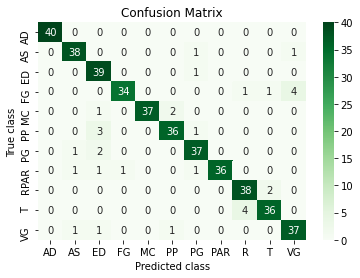

In [0]:
import pandas as pd
import seaborn as sns

CATEGORIES = ['Albrecht_Durer',
 'Alfred_Sisley',
 'Edgar_Degas',
 'Francisco_Goya',
 'Marc_Chagall',
 'Pablo_Picasso',
 'Paul_Gauguin',
 'Pierre-Auguste_Renoir',
 'Rembrandt',
 'Titian',
 'Vincent_van_Gogh']

abbreviation = ['AD', 'AS', 'ED', 'FG', 'MC', 'PP', 'PG', 'PAR', 'R', 'T', 'VG']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})
fig, ax = plt.subplots(1)
ax = sns.heatmap(confusion_matrix_A, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
#fig.savefig('drive/My Drive/503 project dataset/Confusion_matrix.png', dpi=300)
plt.show()

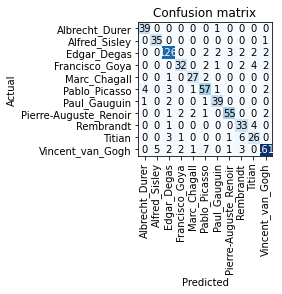

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.most_confused(min_val=n)